In [33]:
import pandas as pd
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import json

In [34]:
# eng_cze
# eng_deu
# eng_fra
# eng_hin
# eng_per
# eng_ron
# eng_tur

In [47]:
lang_pair = "fin_heb"
filetype = "gold" # parallel_sample | gold
target_folder = "silver_data_from_gold"

# filetype = "parallel_sample" # parallel_sample | gold
# target_folder = "silver_data_from_parallel"
df = pd.read_json(f"alternative_data/{lang_pair}/{filetype}_translated_pairs.json")

In [48]:
df

,sentence,sentence_id,word_id,probability,translated_sentences
0,"Salomon , Daavidin pojan , Israelin kuninkaan ...",0,-1,0.000,שלמה בן דוד מלך ישראל משלי
1,"Daavidin , Daavidin pojan , Israelin kuninkaan...",0,0,0.621,משלי דוד בן דוד מלך ישראל
2,"Jeesuksen , Daavidin pojan , Israelin kuninkaa...",0,0,0.171,משלי ישוע בן דוד מלך ישראל
3,"Jumalan , Daavidin pojan , Israelin kuninkaan ...",0,0,0.063,משלי אלהים בן דוד מלך ישראל
4,"Mooseksen , Daavidin pojan , Israelin kuninkaa...",0,0,0.061,משלי משה בן דוד מלך ישראל
...,...,...,...,...,...
2128756,Hän sai panna pois vangin puvun ja aina aterio...,22290,15,0.031,הותר לו לפשוט את חליפת האסיר ולסעוד תמיד במקומ...
2128757,Hän sai panna pois vangin puvun ja aina aterio...,22290,16,0.005,"הותר לו לדחות את חליפת האסיר ולסעוד עמו תמיד ,..."
2128758,Hän sai panna pois vangin puvun ja aina aterio...,22290,16,0.004,"הותר לו לפשוט את חליפת האסיר ולסעוד עמו תמיד ,..."
2128759,Hän sai panna pois vangin puvun ja aina aterio...,22290,16,0.002,"הותר לו לדחות את חליפת האסיר ולסעוד עמו תמיד ,..."


In [49]:
def which_words_changed(sent1, sent2):
    if len(sent1.split())!=len(sent2.split()):
        return [1]*len(sent1.split())
    else:
        x = []
        for a, b in zip(sent1.split(), sent2.split()):
            x.append(int(a!=b))
        return x

In [50]:
final_data = []
sentence_ids = list(set(df["sentence_id"]))
for sentence_id in tqdm(sentence_ids):
    sub_df = df.query(f"sentence_id=={sentence_id}")

    source_sentence = sub_df.query("word_id==-1")["sentence"].iloc[0]
    target_sentence = sub_df.query("word_id==-1")["translated_sentences"].iloc[0]

    ch = defaultdict(list)

    for word_id in range(0, max(sub_df["word_id"])+1):
        elements = sub_df.query(f"word_id=={word_id}").to_dict(orient="records")
        changed_s_sentences = [x["sentence"] for x in elements]
        changed_t_sentences = [x["translated_sentences"] for x in elements]
        for changed_s_sentence, changed_t_sentence in zip(changed_s_sentences, changed_t_sentences):
            changed_words = which_words_changed(target_sentence, changed_t_sentence)
            if len(changed_words)!=sum(changed_words):
                ch[word_id].append(changed_words)
    alignment = []
    for source_word_id in ch:
        temp_alignment = defaultdict(int)
        total = len(ch[source_word_id])
        for one_al in ch[source_word_id]:
            for target_word_id, el in enumerate(one_al):
                if el==1:
                    temp_alignment[(source_word_id, target_word_id)]+=1
        for x in temp_alignment:
            alignment.append({"source_word_id":x[0], "target_word_id":x[1], "freq":temp_alignment[x], "total":total})
            
    
    final_data.append({"source_sentence": source_sentence,
                       "target_sentence": target_sentence,
                       "alignment": alignment,
                       "sentence_id": sentence_id})

100%|██████████| 22291/22291 [15:04<00:00, 24.63it/s]


## Creating Silver Data

In [51]:
import os

In [52]:
en_sentences = df.query("word_id==-1")["sentence"].tolist()
target_sentences = df.query("word_id==-1")["translated_sentences"].tolist()

In [53]:
os.makedirs(f"{target_folder}/{lang_pair}", exist_ok=True)

In [54]:
source_gold_sentences = []
target_gold_sentences = []
r = []
for el in final_data:
    r.append(len([x for x in el["alignment"] if x["freq"]==x["total"] and x["total"]>1])/len(el["source_sentence"].split()))
    source_gold_sentences.append(el["source_sentence"])
    target_gold_sentences.append(el["target_sentence"])

[Text(0.5, 1.0, 'Silver Data Alignment Ratio (Normalized by Word Count)'),
 Text(0.5, 0, 'Ratio')]

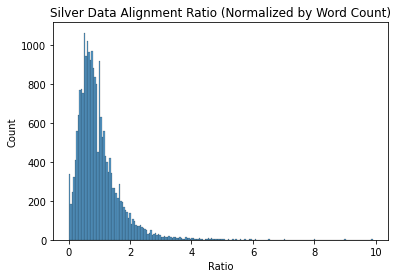

In [55]:
import seaborn as sns
sns.histplot(r).set(title="Silver Data Alignment Ratio (Normalized by Word Count)", xlabel="Ratio")

In [56]:
with open(f"{target_folder}/{lang_pair}/gold.json", "w") as f:
    json.dump(final_data, f)

In [57]:
temp_gold = {}
gold = {}
for idx, x in enumerate(final_data):
    temp_gold[idx] = defaultdict(list)
    multi_keys = set()
    for el in x["alignment"]:
        temp_gold[idx][el["source_word_id"]].append(el["target_word_id"])
        if len(temp_gold[idx][el["source_word_id"]])>1:
            multi_keys.add(el["source_word_id"])
    for el in multi_keys:
        del temp_gold[idx][el]


for idx, x in enumerate(final_data):
    gold[idx] = defaultdict(list)
    for el in x["alignment"]:
        if el["freq"]==el["total"] & el["total"]>3 and el["source_word_id"] in temp_gold[idx] and\
            el["target_word_id"] in temp_gold[idx][el["source_word_id"]]:
            gold[idx][el["source_word_id"]].append(el["target_word_id"])

In [60]:
empty = 0
with open(f"{target_folder}/{lang_pair}/gold.txt", "w") as f, open(f"{target_folder}/{lang_pair}/{lang_pair}.txt", "w") as fg:
    idx = 0
    for el in gold:
        text = f"{idx}\t"
        found = False
        for sw_id in gold[el]:
            for tw_id in gold[el][sw_id]:
                text+= f"{sw_id}-{tw_id} "
                found = True
        if found:
            f.write(text+"\n")
            fg.write(source_gold_sentences[el]+" ||| "+target_gold_sentences[el]+"\n")
            idx+=1
        else:
            empty+=1

In [61]:
empty

17769

eng_cze gold silver_data_from_gold_relaxed


100%|██████████| 2501/2501 [01:39<00:00, 25.25it/s]


eng_deu gold silver_data_from_gold_relaxed


100%|██████████| 508/508 [00:17<00:00, 29.78it/s]


eng_fra gold silver_data_from_gold_relaxed


100%|██████████| 447/447 [00:11<00:00, 38.66it/s]


eng_hin gold silver_data_from_gold_relaxed


100%|██████████| 90/90 [00:02<00:00, 41.12it/s]


eng_per gold silver_data_from_gold_relaxed


100%|██████████| 400/400 [00:17<00:00, 22.74it/s]


eng_ron gold silver_data_from_gold_relaxed


100%|██████████| 199/199 [00:07<00:00, 26.89it/s]


eng_tur gold silver_data_from_gold_relaxed


100%|██████████| 100/100 [00:05<00:00, 18.24it/s]


fin_heb gold silver_data_from_gold_relaxed


100%|██████████| 22291/22291 [17:18<00:00, 21.45it/s]


fin_grc gold silver_data_from_gold_relaxed


100%|██████████| 7909/7909 [04:33<00:00, 28.87it/s]


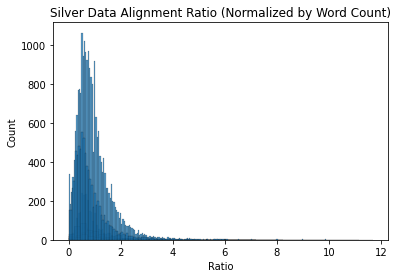

In [1]:
import pandas as pd
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import json

# eng_cze
# eng_deu
# eng_fra
# eng_hin
# eng_per
# eng_ron
# eng_tur

for lang_pair in ["eng_cze", "eng_deu", "eng_fra", "eng_hin", "eng_per", "eng_ron", "eng_tur", "fin_heb", "fin_grc"]:
    for filetype, target_folder in [("gold", "silver_data_from_gold_relaxed")]:
        print(lang_pair, filetype, target_folder)
        df = pd.read_json(f"alternative_data/{lang_pair}/{filetype}_translated_pairs.json")

        df

        def which_words_changed(sent1, sent2):
            if len(sent1.split())!=len(sent2.split()):
                return [1]*len(sent1.split())
            else:
                x = []
                for a, b in zip(sent1.split(), sent2.split()):
                    x.append(int(a!=b))
                return x

        final_data = []
        sentence_ids = list(set(df["sentence_id"]))
        for sentence_id in tqdm(sentence_ids):
            sub_df = df.query(f"sentence_id=={sentence_id}")

            source_sentence = sub_df.query("word_id==-1")["sentence"].iloc[0]
            target_sentence = sub_df.query("word_id==-1")["translated_sentences"].iloc[0]

            ch = defaultdict(list)

            for word_id in range(0, max(sub_df["word_id"])+1):
                elements = sub_df.query(f"word_id=={word_id}").to_dict(orient="records")
                changed_s_sentences = [x["sentence"] for x in elements]
                changed_t_sentences = [x["translated_sentences"] for x in elements]
                for changed_s_sentence, changed_t_sentence in zip(changed_s_sentences, changed_t_sentences):
                    changed_words = which_words_changed(target_sentence, changed_t_sentence)
                    if len(changed_words)!=sum(changed_words):
                        ch[word_id].append(changed_words)
            alignment = []
            for source_word_id in ch:
                temp_alignment = defaultdict(int)
                total = len(ch[source_word_id])
                for one_al in ch[source_word_id]:
                    for target_word_id, el in enumerate(one_al):
                        if el==1:
                            temp_alignment[(source_word_id, target_word_id)]+=1
                for x in temp_alignment:
                    alignment.append({"source_word_id":x[0], "target_word_id":x[1], "freq":temp_alignment[x], "total":total})


            final_data.append({"source_sentence": source_sentence,
                               "target_sentence": target_sentence,
                               "alignment": alignment,
                               "sentence_id": sentence_id})

        ## Creating Silver Data

        import os

        en_sentences = df.query("word_id==-1")["sentence"].tolist()
        target_sentences = df.query("word_id==-1")["translated_sentences"].tolist()

        os.makedirs(f"{target_folder}/{lang_pair}", exist_ok=True)

        source_gold_sentences = []
        target_gold_sentences = []
        r = []
        for el in final_data:
            r.append(len([x for x in el["alignment"] if x["freq"]==x["total"] and x["total"]>1])/len(el["source_sentence"].split()))
            source_gold_sentences.append(el["source_sentence"])
            target_gold_sentences.append(el["target_sentence"])

        import seaborn as sns
        sns.histplot(r).set(title="Silver Data Alignment Ratio (Normalized by Word Count)", xlabel="Ratio")


        with open(f"{target_folder}/{lang_pair}/gold.json", "w") as f:
            json.dump(final_data, f)

        temp_gold = {}
        gold = {}
        for idx, x in enumerate(final_data):
            temp_gold[idx] = defaultdict(list)
            multi_keys = set()
            for el in x["alignment"]:
                temp_gold[idx][el["source_word_id"]].append(el["target_word_id"])
                if len(temp_gold[idx][el["source_word_id"]])>1:
                    multi_keys.add(el["source_word_id"])
            for el in multi_keys:
                del temp_gold[idx][el]


        for idx, x in enumerate(final_data):
            gold[idx] = defaultdict(list)
            for el in x["alignment"]:
                if el["freq"]==el["total"] & el["total"]>=3 and el["source_word_id"] in temp_gold[idx] and\
                    el["target_word_id"] in temp_gold[idx][el["source_word_id"]]:
                    gold[idx][el["source_word_id"]].append(el["target_word_id"])

        with open(f"{target_folder}/{lang_pair}/gold.txt", "w") as f, open(f"{target_folder}/{lang_pair}/{lang_pair}.txt", "w") as fg:
            idx = 0
            for el in gold:
                text = f"{idx}\t"
                found = False
                for sw_id in gold[el]:
                    for tw_id in gold[el][sw_id]:
                        text+= f"{sw_id}-{tw_id} "
                        found = True
                if found:
                    f.write(text+"\n")
                    fg.write(source_gold_sentences[el]+" ||| "+target_gold_sentences[el]+"\n")
                    idx+=1

